# Step 5: Recommender System

To implement the image recommendation functionality for our project, we are following these steps:

1. Image Classification: Utilize our existing machine learning model to classify the user-provided reference image into one of the eight flower classes.
2. Similarity Detection:
    - Use a Convolutional Neural Network (CNN) to extract feature vectors from each image in our database, then store it in `./data/recommender-database.csv`, to allow for efficient retrieval during the recommendation process.
    - Use the same CNN to extract a feature vector from our the user-provided reference image.
    - Apply a K-Means unsupervised machine learning model to cluster the reference image's feature vector with those of the images in our database. We select the number of cluster $k$ dynamically using the number of images need to be recommended.
3. Recommending Images: Once we have the clusters, we would recommend images from the cluster that the reference image belongs to. To do this accurately, we are using [Scikit-learn implementation of cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find the most similar images to the reference image within that cluster.

In [9]:
# Imports and environmental setups
import pandas as pd
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image

# Custom utils functions
from utils import dataset
from utils.visualization import plot_learning_curve
from utils.visualization import visualize_16predictions
from utils.glob import TARGET_IMG_SIZE


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'rec-kmeans'
dir_raw_dataset = '../data/raw/'
dir_recommender_database = 'C:/TaiLieuHocTap/rMIT/A_2023/ML_A23/Rmit-assignment2/data/recommender-database'
path_recommender_database = '../data/recommender-database.csv'
dir_log = '../log/' + model_name
dir_models = '../models/'
path_model = dir_models + model_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


In [10]:
rFlower = dataset.load(dir_recommender_database)
rFlower.head()

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
0,Baby/000001.jpg,jpg,500,667,0.749625,RGB,R G B,False,False,Baby
1,Baby/000002.jpg,jpg,1200,1600,0.750000,RGB,R G B,False,False,Baby
2,Baby/000003.jpg,jpg,2872,2872,1.000000,RGB,R G B,False,False,Baby
3,Baby/000004.jpg,jpg,1667,2334,0.714225,RGB,R G B,False,False,Baby
4,Baby/000005.jpg,jpg,2495,2560,0.974609,RGB,R G B,False,False,Baby


In [11]:
rFlower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685 entries, 0 to 4684
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       4685 non-null   object 
 1   FileType      4685 non-null   object 
 2   Width         4685 non-null   int64  
 3   Height        4685 non-null   int64  
 4   Ratio         4685 non-null   float64
 5   Mode          4685 non-null   object 
 6   Bands         4685 non-null   object 
 7   Transparency  4685 non-null   bool   
 8   Animated      4685 non-null   bool   
 9   Class         4685 non-null   object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 302.1+ KB


In [12]:
print("Number of images: ", len(rFlower))


Number of images:  4685


In [13]:
#load the CNN models
from keras.models import load_model
model = load_model('../models/clf-cnn')
print(model.summary())

Model: "clf-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 4)       196       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 8)       520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0   

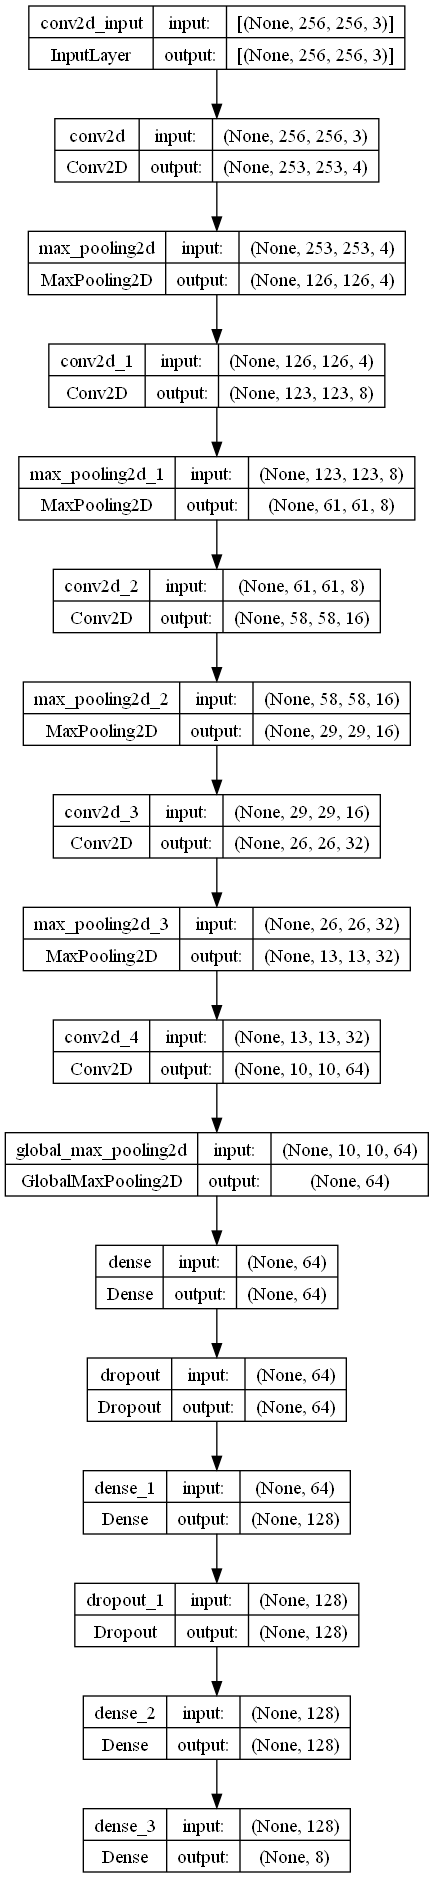

In [14]:
#plot model 
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
dtbase = dir_recommender_database
imgs = []
labels = [] 
for folder in os.listdir(dtbase):
    for img in os.listdir(dtbase + '/' + folder):
        img = Image.open(dtbase + '/' + folder + '/' + img)
        img = img.resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE))
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        imgs.append(img)
        labels.append(folder)

In [ ]:
imgs = np.array(imgs)
labels = np.array(labels)
tensor_array = tf.convert_to_tensor(imgs, dtype=tf.int64)
tensor_labels = tf.convert_to_tensor(labels, dtype=tf.int64)
full = tf.data.Dataset.from_tensor_slices((tensor_array, tensor_labels))

In [ ]:
print(tensor_array.shape)   

(4685, 256, 256, 3)


In [ ]:
features1 = model.predict(tensor_array)
# Normalize features vectors

features1 = features1.reshape(features1.shape[0], -1)  
features1 = (features1 - np.mean(features1, axis=0)) / np.std(features1, axis=0)
#save to csv file
import pandas as pd
csv_df = pd.DataFrame(features1)
csv_df.to_csv('../data/recommender-database.csv', index=False)

147/147 [==============================] - 18s 114ms/step


In [31]:
clean = pd.read_csv('../data/recommender-database.csv')
clean.head(10)


,0,1,2,3,4,5,6,7
0,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
1,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
2,0.034541,-0.110145,-0.163040,0.359001,-0.184186,0.184413,0.238579,-0.224210
3,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
4,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
5,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
6,0.140553,-0.207040,-0.261055,0.142202,-0.264149,0.281390,0.159371,-0.309418
7,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
8,0.817666,-0.829328,-0.825646,-0.867198,-0.733601,0.837273,-0.501186,-0.785466
9,-0.292125,0.302757,0.337045,0.694691,0.217843,-0.358522,0.001789,0.301038


In [23]:
#load the extracted features from the CNN model
tensor_arr = np.load('../data/tensor_imgs.npy')

In [24]:
features = model.predict(tensor_arr)

147/147 [==============================] - 13s 86ms/step


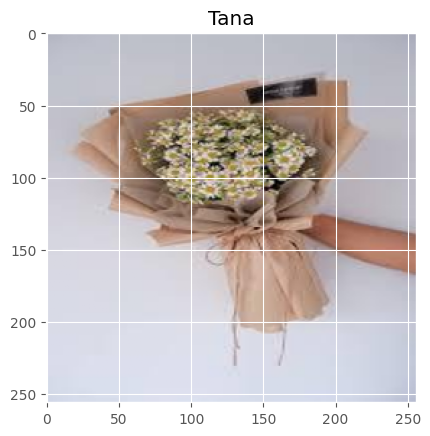

In [48]:
# #open a random image in recommender database
import random
def open_random_image():
    path = dir_recommender_database + '/'
    folder = random.choice(os.listdir(path))
    img = random.choice(os.listdir(path + folder))
    img = Image.open(path + folder + '/' + img)
    img = img.resize((TARGET_IMG_SIZE, TARGET_IMG_SIZE))
    img = np.array(img)
    img = img.astype('float32')
    img /= 255
    plt.imshow(img)
    plt.title(folder)
    plt.show()
    return img

random_img = open_random_image()


In [49]:
classes = dataset.get_class_names(dir_raw_dataset)
print("Classes:", classes)

Classes: ['Baby', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']


In [53]:
# classify the random image into one of eight flowers classes
from keras.models import load_model
def classify_image(random_img, model):
    random_img = random_img.reshape(1, TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)
    model = load_model('../models/clf-cnn')
    
    prediction = model.predict(random_img)
    predicclass = np.argmax(prediction)
        
    class_name = classes
    predicclass = class_name[predicclass]
    return predicclass
classify_image(random_img, model)


1/1 [==============================] - 0s 102ms/step


'Baby'

In [54]:
#kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(features)

c:\TaiLieuHocTap\RMIT\A_2023\ML_A23\rmit-assignment2\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [41]:
# #predict the cluster of the random image
ranImg_features = model.predict(random_img.reshape(1, TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3))
ranImg_features = ranImg_features.reshape(ranImg_features.shape[0], -1)
ranImg_cluster = kmeans.predict(ranImg_features)
ranImg_cluster = ranImg_cluster[0]


1/1 [==============================] - 0s 22ms/step


In [42]:
#find the cluster label of the random image
clutser_label = kmeans.predict(ranImg_features)[0]
clutser_indicies = np.where(kmeans.labels_ == clutser_label)[0]
clutser_images = []
for i in clutser_indicies:
    clutser_images.append(X[i])
clutser_images = np.array(clutser_images)
clutser_images = clutser_images.reshape(clutser_images.shape[0], TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)
clutser_images.shape


(1547, 256, 256, 3)